In [14]:
from osgeo import gdal
from datetime import date, datetime as dt
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

## Read Planet Data

In [2]:
planet_fn = "/data/001_planet_sentinel_study/planet/ndvi/planet_ndvi.vrt"
planet = gdal.Open(planet_fn)

planet_fns = planet.GetFileList()[1:]
planet_dates = [dt.strptime((f.split("/"))[-1][0:15], "%Y%m%d_%H%M%S") for f in planet_fns]

planet_ndvi = planet.ReadAsArray()
print planet_ndvi.shape

(199, 2782, 3448)


## Read Sentinel Data

In [30]:
sentinel_fn = "/data/001_planet_sentinel_study/sentinel/11SKA_NDVI/sen2_ndvi.vrt"
sentinel = gdal.Open(sentinel_fn)

sentinel_fns = sentinel.GetFileList()[1:]
sentinel_dates = [dt.strptime((f.split("/"))[-1][5:20], "%Y%m%d_%H%M%S") for f in sentinel_fns]

sentinel_ndvi = sentinel.ReadAsArray()
print sentinel_ndvi.shape

# Get lat/lon information
transf = sentinel.GetGeoTransform()
reslon = transf[1]
reslat = transf[5]
cols = sentinel.RasterXSize
rows = sentinel.RasterYSize
LHS = transf[0]
THS = transf[3]
BHS = THS + (rows * reslat)
RHS = LHS + (cols * reslon)

latgrid = np.arange(THS, BHS, reslat)
longrid = np.arange(LHS, RHS, reslon)

(12, 2782, 3448)


## Extract Values from NDVI stack

In [195]:
pixel_lat = 36.6591
pixel_lon = -119.928

# ===== GET ROW/COLS FOR PIXEL LAT/LON ===== #

tpix_x = abs(longrid - pixel_lon).argmin()
tpix_y = abs(latgrid - pixel_lat).argmin()

# ===== EXTRACT SENTINEL VALUES ===== #

sentinel_values = []
sentinel_window = []

for i in range(0, (sentinel_ndvi.shape)[0]):
        
    sentinel_values.append(sentinel_ndvi[i, tpix_y, tpix_x])
    sentinel_window.append(np.mean(sentinel_ndvi[i, tpix_y-1:tpix_y+2, tpix_x-1:tpix_x+2]))
    
sentinel_df = pd.DataFrame(index = sentinel_dates)
sentinel_df['ndvi'] = sentinel_values
sentinel_df['window'] = sentinel_window

# ===== EXTRACT PLANET VALUES ===== #

planet_values = []
planet_window = []

for i in range(0, (planet_ndvi.shape)[0]):
        
    planet_values.append(planet_ndvi[i, tpix_y, tpix_x])
    planet_window.append(np.mean(planet_ndvi[i, tpix_y-1:tpix_y+2, tpix_x-1:tpix_x+2]))

planet_df = pd.DataFrame(index = planet_dates)
planet_df['ndvi'] = planet_values
planet_df['window'] = planet_window

# Get rid of NaN values present in a row
planet_df = planet_df[np.isfinite(planet_df['ndvi'])]

print "Done."

Done.


## Extract Values from MODIS csv file

In [196]:
# ===== MOD09 OPENING... ===== #

MOD09 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MOD09/MOD09-MOD09GQ-006-results.csv", index_col=2)

MOD09_df = pd.DataFrame(index = MOD09.index)
MOD09_df['nir'] = MOD09['MOD09GQ_006_sur_refl_b02_1']
MOD09_df['red'] = MOD09['MOD09GQ_006_sur_refl_b01_1']
MOD09 = None

MOD09_df = MOD09_df[MOD09_df.nir < 0.4]

MOD09_df['ndvi'] = ((MOD09_df.nir-MOD09_df.red)/(MOD09_df.nir+MOD09_df.red))

# ===== MYD09 OPENING... ===== #

MYD09 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MYD09/MYD09-MYD09GQ-006-results.csv", index_col=2)

MYD09_df = pd.DataFrame(index = MYD09.index)
MYD09_df['nir'] = MYD09['MYD09GQ_006_sur_refl_b02_1']
MYD09_df['red'] = MYD09['MYD09GQ_006_sur_refl_b01_1']
MYD09 = None

MYD09_df = MYD09_df[MYD09_df.nir < 0.4]

MYD09_df['ndvi'] = ((MYD09_df.nir-MYD09_df.red)/(MYD09_df.nir+MYD09_df.red))


In [197]:
# ===== MCD43 OPENING... ===== #

MCD43 = pd.DataFrame.from_csv("/media/DataShare/Taylor/modis/MCD43/BRDF-MCD43A1-006-results.csv", index_col=2)

MCD43_df = pd.DataFrame(index = MCD43.index)
MCD43_df['nir'] = MCD43['MCD43A1_006_BRDF_Albedo_Parameters_Band2_0']
MCD43_df['red'] = MCD43['MCD43A1_006_BRDF_Albedo_Parameters_Band1_0']
MCD43 = None

#MCD43_df = MCD43_df[MCD43_df.nir < 0.4]

MCD43_df['ndvi'] = ((MCD43_df.nir-MCD43_df.red)/(MCD43_df.nir+MCD43_df.red))

# Plot

<IPython.core.display.Javascript object>


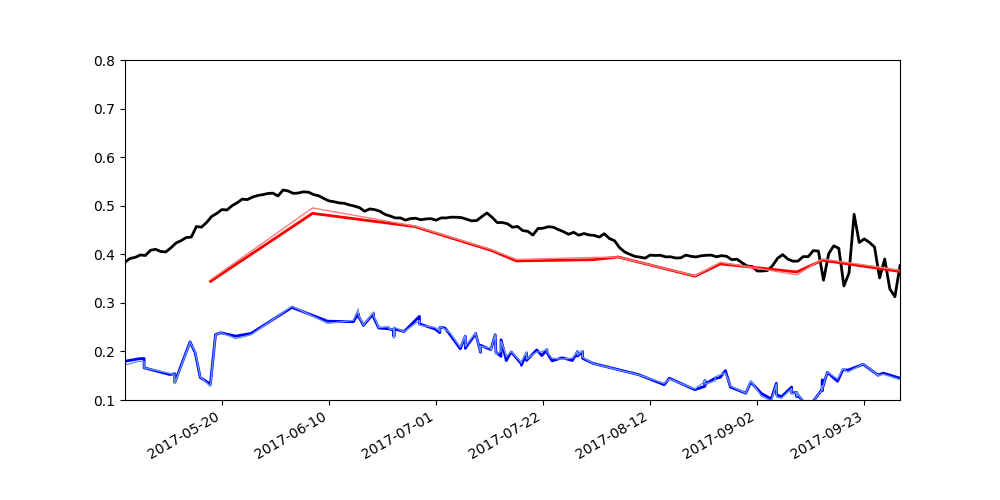

In [202]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot_date(planet_df.index, planet_df['ndvi'], '-', color='Blue', linewidth=2)
ax.plot_date(planet_df.index, planet_df['window'], '-', color='CornflowerBlue', linewidth=1)

# ax.plot_date(MOD09_df.index, MOD09_df['ndvi'], '-', color='darkgray', linewidth=2)
# ax.plot_date(MYD09_df.index, MYD09_df['ndvi'], '-', color='dimgrey', linewidth=2)
ax.plot_date(MCD43_df.index, MCD43_df['ndvi'], '-', color='Black', linewidth=2)

ax.plot_date(sentinel_df.index, sentinel_df['ndvi'], '-', color='red', linewidth=2)
ax.plot_date(sentinel_df.index, sentinel_df['window'], '-', color='lightcoral', linewidth=1)

fig.autofmt_xdate()
ax.set_xlim([date(2017, 5, 1), date(2017, 9, 30)])
ax.set_ylim([0.1, 0.8])
plt.show()

<IPython.core.display.Javascript object>


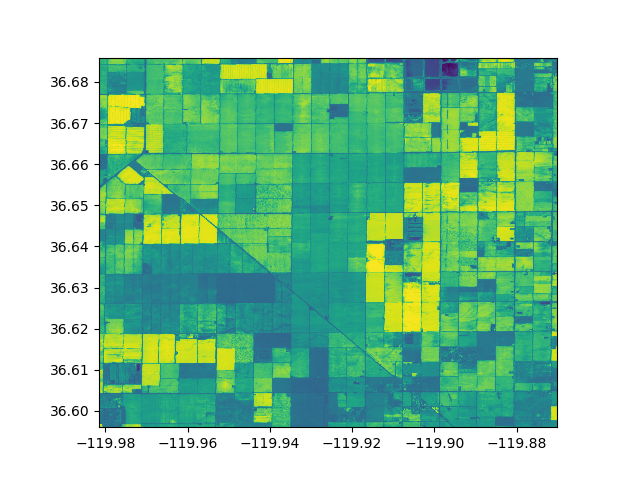

In [132]:
plt.imshow(sentinel_ndvi[5,:,:], extent=[LHS, RHS, BHS, THS])
plt.show()